<a href="https://colab.research.google.com/github/adescofaj/My-Project/blob/main/Solution_file.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
airplanes_data = pd.read_csv("Airplane Locations Data.CSV")
airplanes_data.head()

,Flight No.,Timestamp,Altitude,Latitude,Longitude
0,AA101,1530277200,39000.0,50.9,-38.7
1,AA109,1530277200,33000.0,60.3,-12.2
2,AA111,1530277200,39000.0,52.7,-18.1
3,AA113,1530277200,37000.0,43.0,-11.1
4,AA151,1530277200,36400.0,47.0,-27.7


In [3]:
data = {'Airport No.': ['LHR', 'EWR'], 'Timestamp':[1530277200,1530277200],'Altitude':[81.73,8.72], 'Latitude':[51.4700,40.6895], 'Longitude':[0.4543,-74.1745]}
airports_data = pd.DataFrame(data = data)
airports_data.head()

,Airport No.,Timestamp,Altitude,Latitude,Longitude
0,LHR,1530277200,81.73,51.4700,0.4543
1,EWR,1530277200,8.72,40.6895,-74.1745


In [4]:
# Retrieve nodes name of airplanes and airports
airplanes = airplanes_data['Flight No.'].values.tolist()
airports = airports_data['Airport No.'].values.tolist()
nodes_No = airplanes + airports

In [5]:
# Retrieve (alt, lat, lon) coordinate of airplanes and airports
airplanes_alt_lat_lon = airplanes_data[['Altitude','Latitude', 'Longitude']].values.tolist()
airports_alt_lat_lon = airports_data[['Altitude','Latitude', 'Longitude']].values.tolist()
nodes_alt_lat_lon = airplanes_alt_lat_lon + airports_alt_lat_lon

In [6]:
airplanes_no = len(airplanes_data)
airports_no = len(airports_data)
number_of_nodes = airplanes_no + airports_no

In [7]:
# Convert (alt, lat, lon) to (x,y,z)
def xyz(alt, lat, lon):
    alt *= 0.0003048
    lat *= np.pi / 180
    lon *= np.pi / 180
    
    R = 6371 + alt
    
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R * np.sin(lat)
    return x, y, z
xyz_pos = []
for pos in nodes_alt_lat_lon:
    alt, lat, lon = pos
    x, y, z = xyz(alt, lat, lon)
    xyz_pos.append([x, y, z])
xyz_pos[:5]

[[3141.6479988555006, -2516.9346576018434, 4953.416678271045],
 [3090.1499028687226, -668.1140577495328, 5542.788421710541],
 [3676.552650273798, -1201.682636835888, 5077.4174988881605],
 [4580.382071321852, -898.6352351023596, 4352.702856663619],
 [3853.7449343823027, -2023.261323428638, 4667.568597556164]]

In [8]:
def calculate_distance(node1, node2):
    return np.linalg.norm(np.array(node2)-np.array(node1),2)
def calculate_rate(distance):
    if distance == 0 or distance > 740:
        return 0
    elif distance <= 35:
        return 119.130
    elif distance <= 90:
        return 93.854
    elif distance <= 190:
        return 77.071
    elif distance <= 300:
        return 63.970
    elif distance <= 400:
        return 52.857
    elif distance <= 500:
        return 43.505
    elif distance <= 740:
        return 31.895
matrix_of_distances = np.zeros((number_of_nodes, number_of_nodes))
matrix_of_rates = np.zeros((number_of_nodes, number_of_nodes))
for fr in range(number_of_nodes):
    for to in range(fr + 1, number_of_nodes):
        distance = calculate_distance(xyz_pos[fr], xyz_pos[to])
        rate = calculate_rate(distance)
        matrix_of_distances[fr, to] = matrix_of_distances[to, fr] = distance
        matrix_of_rates[fr, to] = matrix_of_rates[to, fr] = rate

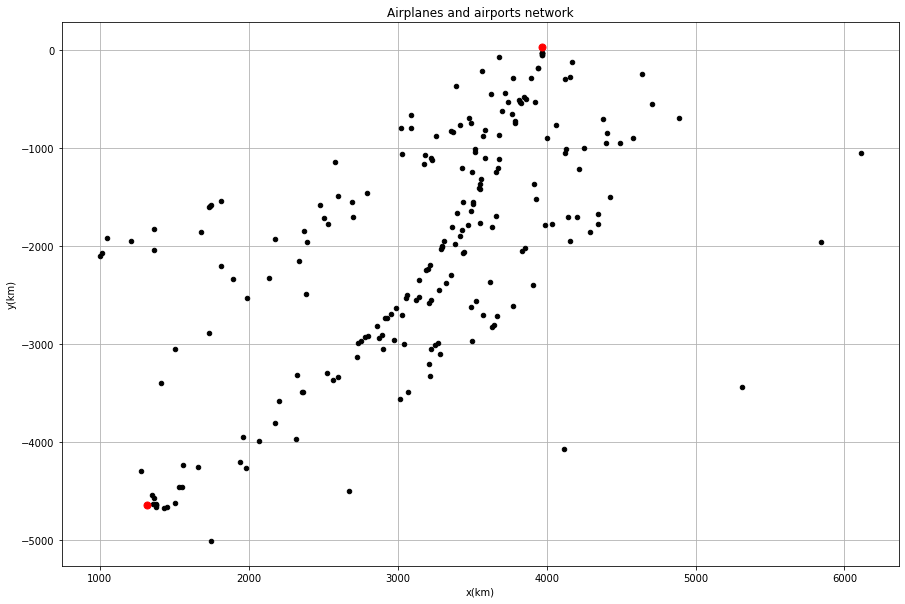

In [9]:
class graph():
    def __init__(self, nodes, pos, airports, links):
        self.nodes = nodes
        self.pos = pos
        self.airports = airports
        self.links = links
    def show(self, title = "Plot of airplanes and airports"):
        plt.figure(figsize=(15,10))
        
        for i in range(len(self.nodes)):
            node = self.nodes[i]
            if node not in self.airports:
                plt.plot(self.pos[i][0], self.pos[i][1], 'k.', markersize = 9)
            else:
                plt.plot(self.pos[i][0], self.pos[i][1], 'r.', markersize = 14)
        for link in self.links:
            fr, to = link
            plt.plot([self.pos[fr][0], self.pos[to][0]], [self.pos[fr][1], self.pos[to][1]], 'b', linewidth = 2, alpha = 0.6)
        plt.title(title)
        plt.xlabel('x(km)')
        plt.ylabel('y(km)')
        plt.grid(True)
        plt.show()
G = graph(nodes_No, xyz_pos, airports, []) 
G.show(title = "Airplanes and airports network")
#From the chart, the dots that aren’t together with the other dots are the airplanes that didn’t connect.
#The red dots represent each ground station (GS) while the blue dots represent each node (airline).
#The airplanes closer to the ground stations will have a higher data transmission rate.

In [10]:

def select_new_node(current_node, set_possible_nodes):        
    p_num = probability[current_node, set_possible_nodes]
    if np.random.random() < select_best:
        new_node = np.argmax(p_num)
    else:
        denominator = sum(p_num)
        if denominator:
            probabilities = p_num / denominator
            new_node = np.random.choice(range(len(probabilities)), p = probabilities)
        else:
            new_node = np.random.choice(range(len(set_possible_nodes)))
            
    return set_possible_nodes[new_node]
def route_evaluation(route):
    rate = 119.130
    for n in range(1, len(route)):
        if matrix_of_rates[route[n-1], route[n]] < rate:
            rate = matrix_of_rates[route[n-1], route[n]]
    return rate
def routes_evaluation(routes):
    scores = []
    for route in routes:
        scores.append(route_evaluation(route))
    return scores
def choose_best_route(routes, scores):
    ind = 0
    rate = scores[ind]
    for i in range(1, len(scores)):
        if rate < scores[i]:
            rate = scores[i]
            ind = i
    return routes[ind], scores[ind]



def create_route(start, set_possible_nodes, probability):
    
    current_node = start
    route = [current_node]
    set_possible_nodes.remove(current_node)
    
    while nodes_No[current_node] not in airports:
        if connections[current_node] != None:
            current_node = connections[current_node]
        else:
            current_node = select_new_node(current_node, set_possible_nodes)
        route.append(current_node)
        set_possible_nodes.remove(current_node)
    return route
def reset_nodes():
    return set_possible_nodes_a.copy()
def update_pheromone(pheromone, routes, scores):
    for j in range(len(routes)):
        score = scores[j]
        route = routes[j]
        for i in range(len(route)-1):
            fr = route[i]
            to = route[i+1]
            pheromone[fr][to] += 0.01 * score
    return pheromone

def update_heuristic_coeff(alpha_heuristic, beta_heuristic):
    alpha_heuristic *= 0.99
    beta_heuristic *= 1.01
    return alpha_heuristic, beta_heuristic

def update_probability(pheromone, heuristic, alpha_heuristic, beta_heuristic):
    return (pheromone ** alpha_heuristic) * (heuristic ** beta_heuristic)
# Run ACO algorithm
connections = {airplane:None for airplane in range(airplanes_no)}
for airplane in range(airplanes_no):
    max_iterations = 10
    number_of_ants = 100
    alpha_heuristic = 1.0
    beta_heuristic = 1.0
    heuristic = matrix_of_rates
    num_nodes = len(matrix_of_rates)
    pheromone = np.ones((num_nodes, num_nodes))        
    pheromone[np.eye(num_nodes) == 1] = 0 

    probability = (pheromone ** alpha_heuristic) * (heuristic ** beta_heuristic) 
    set_possible_nodes_a = list(range(num_nodes))
    select_best = 0.1
    gbest_rate = 0
    gbest_route = []
    routes = []
    set_possible_nodes = reset_nodes()
    
    for iteration in range(max_iterations):
        for ant in range(number_of_ants):
            routes.append(create_route(airplane, set_possible_nodes.copy(), probability))
        
        scores = routes_evaluation(routes)
        best_route, best_rate = choose_best_route(routes, scores)
        if best_rate > gbest_rate:
            gbest_rate = best_rate
            gbest_route = best_route
        
        set_possible_nodes = reset_nodes()
        pheromone = update_pheromone(pheromone, routes, scores)
        alpha_heuristic, beta_heuristic = update_heuristic_coeff(alpha_heuristic, beta_heuristic)
        probability = update_probability(pheromone, heuristic, alpha_heuristic, beta_heuristic)
    
    if(len(gbest_route)) > 1:
        connections[airplane] = gbest_route[1]
        if gbest_rate > 0:
            for n in range(1, len(gbest_route)-1):
                new_route = gbest_route[n:]
                new_rate = route_evaluation(new_route)
                if connections[gbest_route[n]] == None:
                    connections[gbest_route[n]] = new_route[1]   

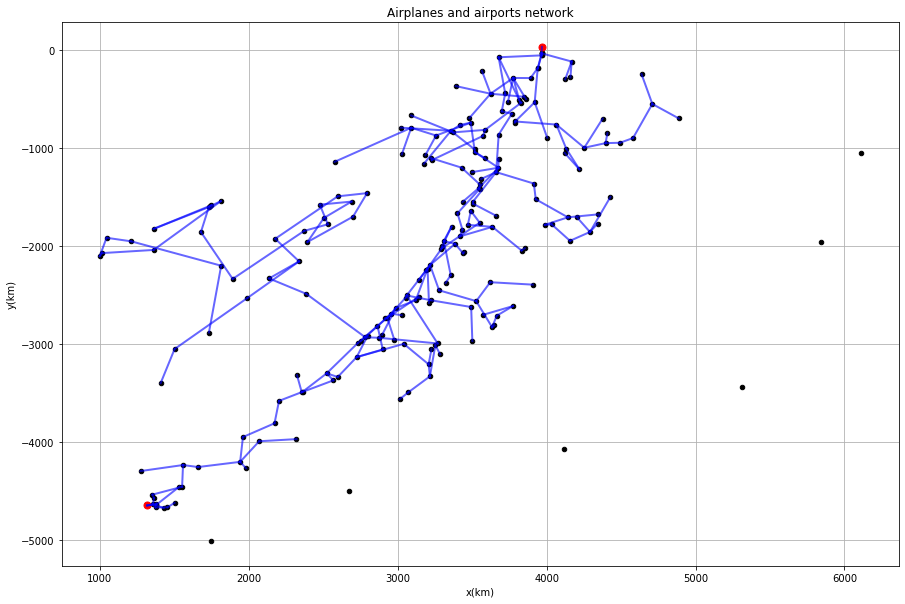

In [11]:
links = []
for airplane in range(airplanes_no):
    to = connections[airplane]
    if to:
        links.append((airplane, to))
G = graph(nodes_No, xyz_pos, airports, links) 
G.show(title = "Airplanes and airports network")
#From the chart, the dots that aren’t together with the other dots are the airplanes that didn’t connect.
#The red dots represent each ground station (GS) while the blue dots represent each node (airline).
#The airplanes closer to the ground stations will have a higher data transmission rate.

In [12]:
final_rates = [0 for airplane in range(airplanes_no)]
final_delays = [0 for airplane in range(airplanes_no)]
with open("problem1.txt", "w") as outfile:
    for airplane in range(airplanes_no):
        rate = 119.130
        delay = 0
        if connections[airplane] != None:
            fr = airplane
            print("{}'{}': 'routing-path':".format('{',nodes_No[airplane]), end = '', file = outfile)
            while nodes_No[fr] not in airports and connections[fr] != None:
                to = connections[fr]
                print("('{}', {}), ".format(nodes_No[to], matrix_of_rates[fr][to]), end = '', file = outfile)
                if rate > matrix_of_rates[fr][to]:
                    rate = matrix_of_rates[fr][to]
                delay += 50
                fr = to
            final_rates[airplane] = rate
            final_delays[airplane] = delay
        print("end-to-end data rate:'{}'{}".format(rate,'}'), file = outfile)
with open("problem1.txt", "r") as outfile:
    print(outfile.read())


{'AA101': 'routing-path':('DL43', 52.857), ('UA160', 63.97), ('DL91', 119.13), ('DL17', 63.97), ('DL81', 63.97), ('AA723', 119.13), ('LH444', 52.857), ('UA24', 77.071), ('UA961', 77.071), ('UA975', 63.97), ('DL87', 63.97), ('UA951', 93.854), ('UA53', 77.071), ('AA53', 63.97), ('AA731', 93.854), ('UA147', 63.97), ('BA191', 63.97), ('AA87', 119.13), ('DL155', 43.505), ('UA127', 93.854), ('LH422', 52.857), ('BA213', 119.13), ('LH492', 43.505), ('BA49', 52.857), ('LHR', 93.854), end-to-end data rate:'43.505'}
{'AA109': 'routing-path':('DL163', 52.857), ('UA127', 63.97), ('LH422', 52.857), ('BA213', 119.13), ('LH492', 43.505), ('BA49', 52.857), ('LHR', 93.854), end-to-end data rate:'43.505'}
{'AA111': 'routing-path':('UA988', 93.854), ('DL31', 52.857), ('AA39', 63.97), ('BA2271', 93.854), ('UA153', 77.071), ('LH492', 52.857), ('BA49', 52.857), ('LHR', 93.854), end-to-end data rate:'52.857'}
{'AA113': 'routing-path':('AA743', 77.071), ('BA249', 77.071), ('DL213', 63.97), ('DL501', 52.857), (

In [13]:
mean_delay = sum(final_delays) / len(final_delays)
mean_rate = sum(final_rates) / len(final_rates)
print('Average of delays is: ', mean_delay, 'ms')
print('Average of rates is : ', mean_rate, 'Mbps')

Average of delays is:  748.3796296296297 ms
Average of rates is :  50.70235648148147 Mbps


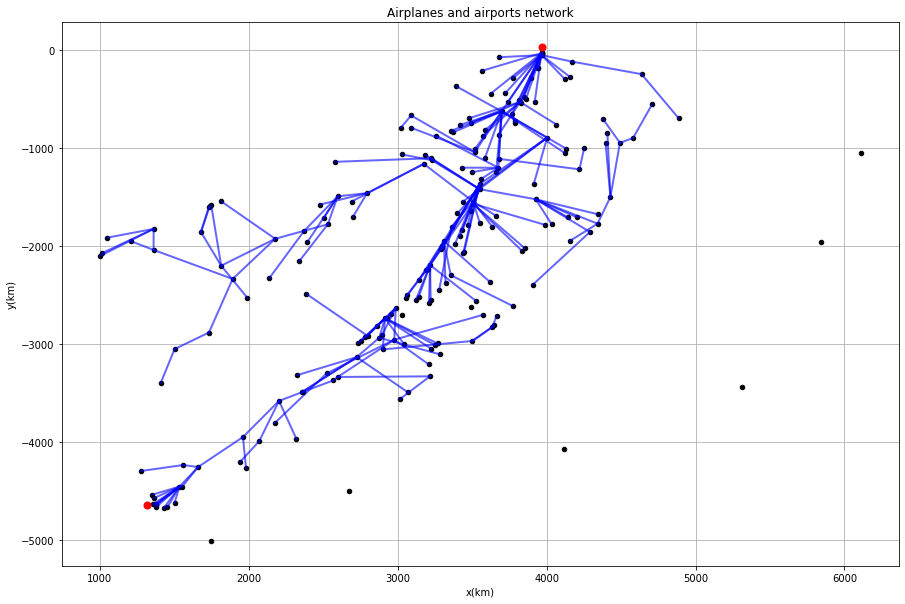

In [14]:
def dominate(s1, s2):
    if (s1[0] > s2[0] and s1[1] <= s2[1]) or (s1[0] >= s2[0] and s1[1] < s2[1]):
        return True
    else:
        return False
def Astar(rates, airport):
    def choose_best_score(scores, unvisited):
        ind = unvisited[0]
        score = scores[ind]
        for node in unvisited:
            if dominate(scores[node], score):
                score = scores[node]
                ind = node
        return ind
    node_num = len(rates)
    unvisited = [node for node in range(node_num)]
    scores = [(0, 100000) for _ in range(node_num)]
    scores[airport] = (119.130, 0)
    connections = {node: None for node in range(node_num)}
    while len(unvisited):
        current_node = choose_best_score(scores, unvisited)
        unvisited.remove(current_node)
        
        for node in range(node_num):
            new_score = (min(scores[current_node][0], scores[node][0] + rates[current_node][node]), scores[current_node][0] + 50)
            if dominate(new_score, scores[node]) and node != current_node:
                scores[node] = new_score
                connections[node] = current_node
    return connections, scores
def run_astar_algorithm():
    connections_list = []
    scores = []
    for airport in range(airplanes_no, number_of_nodes):
        connect_to, scores_vec = Astar(matrix_of_rates, airport)
        connections_list.append(connect_to)
        scores.append(scores_vec)
    links = []
    connections = {node: None for node in range(number_of_nodes)}
    for airplane in range(airplanes_no):
        best_score = scores[0][airplane]
        to = connections_list[0][airplane]
        for airport in range(1, airports_no):
            if dominate(scores[airport][airplane], best_score):
                best_score = scores[airport][airplane]
                to = connections_list[airport][airplane]
        
        if to and best_score[0] > 0 and connections[to] != airplane:
            links.append((airplane, to))
            connections[airplane] = to
    return connections, links

connections, links = run_astar_algorithm()
G = graph(nodes_No, xyz_pos, airports, links) 
G.show(title = "Airplanes and airports network")               
#From the chart, the dots that aren’t together with the other dots are the airplanes that didn’t connect.
#The red dots represent each ground station (GS) while the blue dots represent each node (airline).
#The airplanes closer to the ground stations will have a higher data transmission rate.

In [15]:
final_rates = [0 for airplane in range(airplanes_no)]
final_delays = [0 for airplane in range(airplanes_no)]
with open("problem2.txt", "w") as outfile:
    for airplane in range(airplanes_no):
        rate = 119.130
        delay = 0
        if connections[airplane] != None:
            fr = airplane
            print("{}'{}': 'routing-path':".format('{',nodes_No[airplane]), end = '', file = outfile)
            while nodes_No[fr] not in airports and connections[fr] != None:
                to = connections[fr]
                print("('{}', {}), ".format(nodes_No[to], matrix_of_rates[fr][to]), end = '', file = outfile)
                if rate > matrix_of_rates[fr][to]:
                    rate = matrix_of_rates[fr][to]
                delay += 50
                fr = to
            final_rates[airplane] = rate
            final_delays[airplane] = delay
        print("end-to-end data rate:'{}'{}".format(rate,'}'), file = outfile)
with open("problem2.txt", "r") as outfile:
    print(outfile.read())
mean_delay = sum(final_delays) / len(final_delays)
mean_rate = sum(final_rates) / len(final_rates)
print('Average of delays is: ', mean_delay, 'ms')
print('Average of rates is : ', mean_rate, 'Mbps')

{'AA101': 'routing-path':('BA185', 52.857), ('AA723', 77.071), ('AA731', 31.895), ('AA715', 31.895), ('BA2271', 43.505), ('BA225', 31.895), end-to-end data rate:'31.895'}
{'AA109': 'routing-path':('AA97', 31.895), ('BA2271', 43.505), ('BA225', 31.895), end-to-end data rate:'31.895'}
{'AA111': 'routing-path':('BA2271', 31.895), ('BA225', 31.895), end-to-end data rate:'31.895'}
{'AA113': 'routing-path':('AA743', 77.071), ('AA741', 31.895), ('AA259', 63.97), ('AA93', 31.895), ('AA53', 31.895), ('AA715', 31.895), ('BA2271', 43.505), ('BA225', 31.895), end-to-end data rate:'31.895'}
{'AA151': 'routing-path':('AA735', 31.895), ('AA53', 77.071), ('AA715', 31.895), ('BA2271', 43.505), ('BA225', 31.895), end-to-end data rate:'31.895'}
{'AA198': 'routing-path':('DL118', 52.857), ('BA178', 63.97), ('DL71', 43.505), ('UA22', 43.505), ('AA705', 43.505), ('AA51', 93.854), ('AA45', 31.895), ('AA717', 52.857), end-to-end data rate:'31.895'}
{'AA199': 'routing-path':('AA53', 77.071), ('AA715', 31.895),

In [16]:
mean_delay = sum(final_delays) / len(final_delays)
mean_rate = sum(final_rates) / len(final_rates)
print('Average of delays is: ', mean_delay, 'ms')
print('Average of rates is : ', mean_rate, 'Mbps')

Average of delays is:  222.22222222222223 ms
Average of rates is :  35.40301851851868 Mbps
